#Transformers- The engine of LLMs


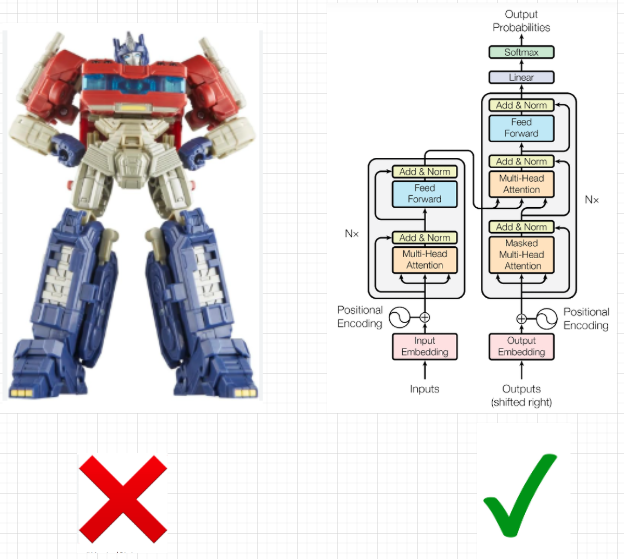

## Block Diagram

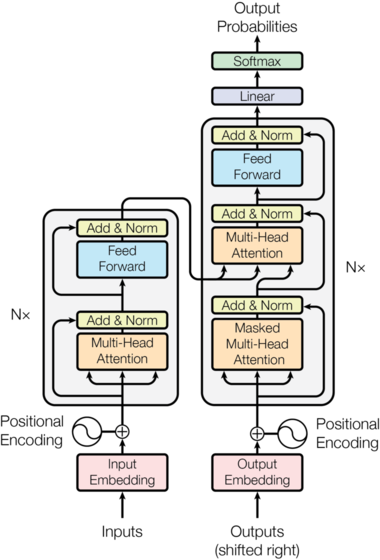

In [27]:
# !pip install datasets
!pip install -U datasets huggingface_hub fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [28]:
# Importing libraries

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# Math
import math

# HuggingFace libraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Pathlib
from pathlib import Path

# typing
from typing import Any

# Library for progress bars in loops
from tqdm import tqdm

# Importing library of warnings
import warnings

## Embedding Layer

In [29]:
# Creating Input Embeddings
class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model # Dimension of vectors (512)
        self.vocab_size = vocab_size # Size of the vocabulary
        self.embedding = nn.Embedding(vocab_size, d_model) # PyTorch layer that converts integer indices to dense embeddings

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model) # Normalizing the variance of the embeddings

##Positional Embedding

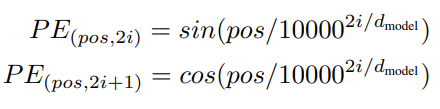



```
Dim = 4
["The", "cat" , "sat", "on", "the" ,"mat"]
Embeddings ={E1​,E2​,E3​,E4​,E5​,E6​}
```

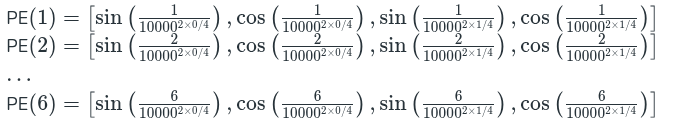


In [30]:
# Creating the Positional Encoding
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Dimensionality of the model
        self.seq_len = seq_len # Maximum sequence length
        self.dropout = nn.Dropout(dropout) # Dropout layer to prevent overfitting

        # Creating a positional encoding matrix of shape (seq_len, d_model) filled with zeros
        pe = torch.zeros(seq_len, d_model) #100x512

        # Creating a tensor representing positions (0 to seq_len - 1)
        position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1) # Transforming 'position' into a 2D tensor['seq_len, 1']

        # Creating the division term for the positional encoding formula
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices in pe
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in pe
        pe[:, 1::2] = torch.cos(position * div_term)

        # Adding an extra dimension at the beginning of pe matrix for batch handling
        pe = pe.unsqueeze(0)

        # Registering 'pe' as buffer. Buffer is a tensor not considered as a model parameter
        self.register_buffer('pe', pe)

    def forward(self,x):
        # Addind positional encoding to the input tensor X
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x) # Dropout for regularization

## Layer Normalization

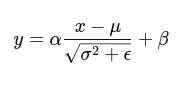

In [31]:
# Creating Layer Normalization
class LayerNormalization(nn.Module):

    def __init__(self, eps: float = 10**-6) -> None: # We define epsilon as 0.000001 to avoid division by zero
        super().__init__()
        self.eps = eps

        # We define alpha as a trainable parameter and initialize it with ones
        self.alpha = nn.Parameter(torch.ones(1)) # One-dimensional tensor that will be used to scale the input data

        # We define bias as a trainable parameter and initialize it with zeros
        self.bias = nn.Parameter(torch.zeros(1)) # One-dimensional tenso that will be added to the input data

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True) # Computing the mean of the input data. Keeping the number of dimensions unchanged
        std = x.std(dim = -1, keepdim = True) # Computing the standard deviation of the input data. Keeping the number of dimensions unchanged

        # Returning the normalized input
        return self.alpha * (x-mean) / (std + self.eps) + self.bias

## Feed-Forward Network

In [32]:
# Creating Feed Forward Layers
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        # First linear transformation
        self.linear_1 = nn.Linear(d_model, d_ff) # W1 & b1
        self.dropout = nn.Dropout(dropout) # Dropout to prevent overfitting
        # Second linear transformation
        self.linear_2 = nn.Linear(d_ff, d_model) # W2 & b2

    def forward(self, x):
        # (Batch, seq_len, d_model) --> (batch, seq_len, d_ff) -->(batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

## Multi-Head Attention

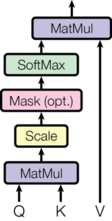


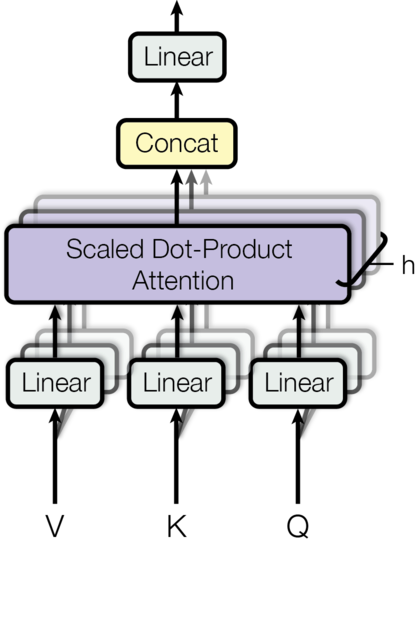

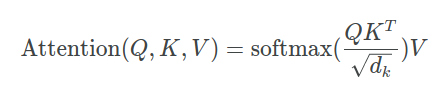

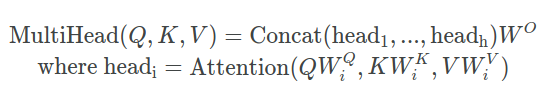

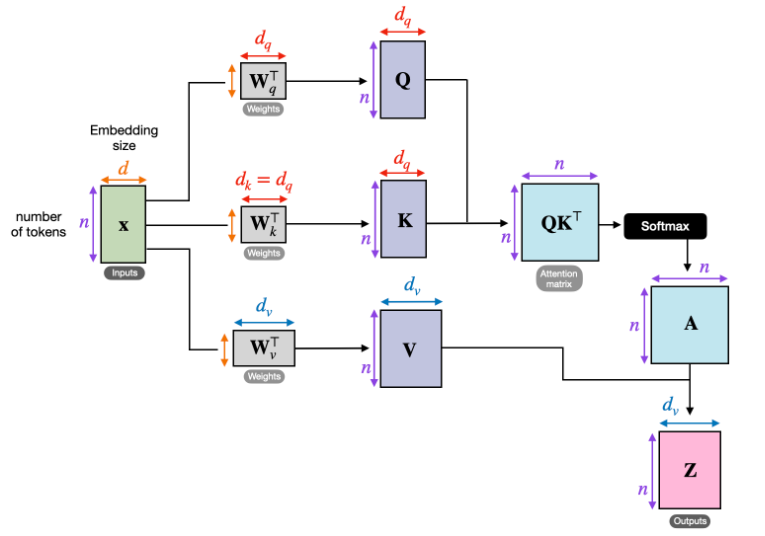

In [33]:
# Creating the Multi-Head Attention block
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None: # h = number of heads
        super().__init__()
        self.d_model = d_model
        self.h = h

        # We ensure that the dimensions of the model is divisible by the number of heads
        assert d_model % h == 0, 'd_model is not divisible by h'

        # d_k is the dimension of each attention head's key, query, and value vectors
        self.d_k = d_model // h # d_k formula, like in the original "Attention Is All You Need" paper

        # Defining the weight matrices
        self.w_q = nn.Linear(d_model, d_model) # W_q
        self.w_k = nn.Linear(d_model, d_model) # W_k
        self.w_v = nn.Linear(d_model, d_model) # W_v
        self.w_o = nn.Linear(d_model, d_model) # W_o

        self.dropout = nn.Dropout(dropout) # Dropout layer to avoid overfitting


    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):# mask => When we want certain words to NOT interact with others, we "hide" them

        d_k = query.shape[-1] # The last dimension of query, key, and value

        # We calculate the Attention(Q,K,V) as in the formula in the image above
        attention_scores = (query @ key.transpose(-2,-1)) / math.sqrt(d_k) # @ = Matrix multiplication sign in PyTorch
        #print(f'shape of attention_scores:{attention_scores.shape}')

        # Before applying the softmax, we apply the mask to hide some interactions between words
        if mask is not None: # If a mask IS defined...
            attention_scores.masked_fill_(mask == 0, -1e9) # Replace each value where mask is equal to 0 by -1e9
        attention_scores = attention_scores.softmax(dim = -1) # Applying softmax
        if dropout is not None: # If a dropout IS defined...
            attention_scores = dropout(attention_scores) # We apply dropout to prevent overfitting

        return (attention_scores @ value), attention_scores # Multiply the output matrix by the V matrix, as in the formula

    def forward(self, q, k, v, mask):
        print(f'shape of input to query:{q.shape}')
        query = self.w_q(q) # Q' matrix
        print(query.shape)
        #print(f'shape of query:{query.shape}')
        key = self.w_k(k) # K' matrix
        value = self.w_v(v) # V' matrix


        # Splitting results into smaller matrices for the different heads
        # Splitting embeddings (third dimension) into h parts
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
        print(f'shape of query after head organization:{query.shape}')
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension

        # Obtaining the output and the attention scores
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # Obtaining the H matrix
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x) # Multiply the H matrix by the weight matrix W_o, resulting in the MH-A matrix



```
Input Shape: [B, S, D]
After multiplying with key, query and value projection Matrices
Q Shape = K Shape = V Shape: [B, S, D]
Splitting for multiple heads: [B, h, S, D1]  => hence we check whether Hidden Dim D Length S is divisible by num heads h
```



## Residual Connection

In [34]:
# Building Residual Connection
class ResidualConnection(nn.Module):
    def __init__(self, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout) # We use a dropout layer to prevent overfitting
        self.norm = LayerNormalization() # We use a normalization layer

    def forward(self, x, sublayer):
        # We normalize the input and add it to the original input 'x'. This creates the residual connection process.
        return x + self.dropout(sublayer(self.norm(x)))

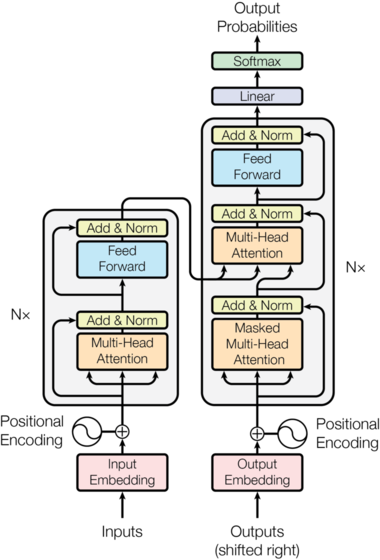

##Encoder

In [35]:
# Building Encoder Block
class EncoderBlock(nn.Module):

    # This block takes in the MultiHeadAttentionBlock and FeedForwardBlock, as well as the dropout rate for the residual connections
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        # Storing the self-attention block and feed-forward block
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)]) # 2 Residual Connections with dropout

    def forward(self, x, src_mask):
        #define here
        # Applying the first residual connection with the self-attention block
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask)) # Three 'x's corresponding to query, key, and value inputs plus source mask

        # Applying the second residual connection with the feed-forward block
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x # Output tensor after applying self-attention and feed-forward layers with residual connections.

In [36]:
# Building Encoder
# An Encoder can have several Encoder Blocks
class Encoder(nn.Module):

    # The Encoder takes in instances of 'EncoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers # Storing the EncoderBlocks
        self.norm = LayerNormalization() # Layer for the normalization of the output of the encoder layers

    def forward(self, x, mask):
        # Iterating over each EncoderBlock stored in self.layers
        for layer in self.layers:
            x = layer(x, mask) # Applying each EncoderBlock to the input tensor 'x'
        return self.norm(x) # Normalizing output

## Decoder

In [37]:
class DecoderBlock(nn.Module):

    # The DecoderBlock takes in two MultiHeadAttentionBlock. One is self-attention, while the other is cross-attention.
    # It also takes in the feed-forward block and the dropout rate
    def __init__(self,  self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)]) # List of three Residual Connections with dropout rate

    def forward(self, x, encoder_output, src_mask, tgt_mask):

        # Self-Attention block with query, key, and value plus the target language mask
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))

        # The Cross-Attention block using two 'encoder_ouput's for key and value plus the source language mask. It also takes in 'x' for Decoder queries
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))

        # Feed-forward block with residual connections
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x


In [38]:
# Building Decoder
# A Decoder can have several Decoder Blocks
class Decoder(nn.Module):

    # The Decoder takes in instances of 'DecoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()

        # Storing the 'DecoderBlock's
        self.layers = layers
        self.norm = LayerNormalization() # Layer to normalize the output

    def forward(self, x, encoder_output, src_mask, tgt_mask):

        # Iterating over each DecoderBlock stored in self.layers
        for layer in self.layers:
            # Applies each DecoderBlock to the input 'x' plus the encoder output and source and target masks
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x) # Returns normalized output

In [39]:
# Buiding Linear Layer
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None: # Model dimension and the size of the output vocabulary
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size) # Linear layer for projecting the feature space of 'd_model' to the output space of 'vocab_size'
    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim = -1) # Applying the log Softmax function to the output

## Transformer - Putting it all together

In [40]:
# Creating the Transformer Architecture
class Transformer(nn.Module):

    # This takes in the encoder and decoder, as well the embeddings for the source and target language.
    # It also takes in the Positional Encoding for the source and target language, as well as the projection layer
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    # Encoder
    def encode(self, src, src_mask):
        src = self.src_embed(src) # Applying source embeddings to the input source language
        src = self.src_pos(src) # Applying source positional encoding to the source embeddings
        #print(f'Encoder input after converting to embeddings:{src.shape}')
        return self.encoder(src, src_mask) # Returning the source embeddings plus a source mask to prevent attention to certain elements

    # Decoder
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt) # Applying target embeddings to the input target language (tgt)
        tgt = self.tgt_pos(tgt) # Applying target positional encoding to the target embeddings
        #print(f'Decoder input after converting to embeddings:{tgt.shape}')

        # Returning the target embeddings, the output of the encoder, and both source and target masks
        # The target mask ensures that the model won't 'see' future elements of the sequence
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    # Applying Projection Layer with the Softmax function to the Decoder output
    def project(self, x):
        return self.projection_layer(x)

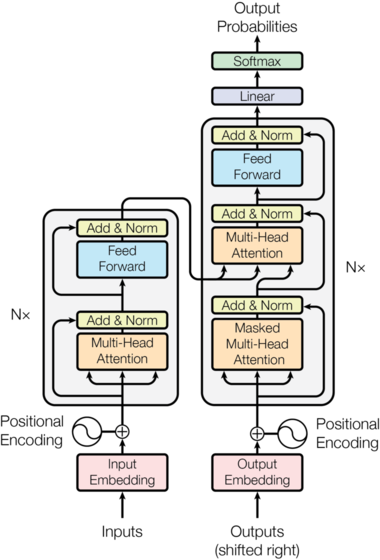



```
En: I love the weather   It: X Y Z K
E = Encoder(I love the weather)
Autoregressive Decoding:
X -> E, Decoder State(SoS)
Y -> E, Decoder State(SoS, X)
Z -> E, Decoder State(Sos, X, Y)
K -> E, Decoder State(Sos, X, Y, Z)
```



In [41]:
# Building & Initializing Transformer

# Definin function and its parameter, including model dimension, number of encoder and decoder stacks, heads, etc.
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:

    # Creating Embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size) # Source language (Source Vocabulary to 512-dimensional vectors)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size) # Target language (Target Vocabulary to 512-dimensional vectors)

    # Creating Positional Encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout) # Positional encoding for the source language embeddings
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout) # Positional encoding for the target language embeddings

    # Creating EncoderBlocks
    encoder_blocks = [] # Initial list of empty EncoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' EncoderBlocks (N = 6)
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward

        # Combine layers into an EncoderBlock
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block) # Appending EncoderBlock to the list of EncoderBlocks

    # Creating DecoderBlocks
    decoder_blocks = [] # Initial list of empty DecoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' DecoderBlocks (N = 6)
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Cross-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward

        # Combining layers into a DecoderBlock
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block) # Appending DecoderBlock to the list of DecoderBlocks

    # Creating the Encoder and Decoder by using the EncoderBlocks and DecoderBlocks lists
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))

    # Creating projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size) # Map the output of Decoder to the Target Vocabulary Space

    # Creating the transformer by combining everything above
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer # Assembled and initialized Transformer. Ready to be trained and validated!

## Tokenizer

In [42]:
# Defining Tokenizer
def build_tokenizer(config, ds, lang):

    # Crating a file path for the tokenizer
    tokenizer_path = Path(config['tokenizer_file'].format(lang))

    # Checking if Tokenizer already exists
    if not Path.exists(tokenizer_path):

        # If it doesn't exist, we create a new one
        tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]')) # Initializing a new word-level tokenizer
        tokenizer.pre_tokenizer = Whitespace() # We will split the text into tokens based on whitespace

        # Creating a trainer for the new tokenizer
        trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]",
                                                     "[SOS]", "[EOS]"], min_frequency = 2) # Defining Word Level strategy and special tokens

        # Training new tokenizer on sentences from the dataset and language specified
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
        tokenizer.save(str(tokenizer_path)) # Saving trained tokenizer to the file path specified at the beginning of the function
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path)) # If the tokenizer already exist, we load it
    return tokenizer # Returns the loaded tokenizer or the trained tokenizer

##Loading Dataset

In [43]:
# Iterating through dataset to extract the original sentence and its translation
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair['translation'][lang]

In [44]:
def get_ds(config):

    # Loading the train portion of the OpusBooks dataset.
    # The Language pairs will be defined in the 'config' dictionary we will build later
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train')
    print(ds_raw)

    # Building or loading tokenizer for both the source and target languages
    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])

    # print(f'Source Tokenizer:{tokenizer_src}')
    # print(f'Target Tokenizer:{tokenizer_tgt}')

    # Splitting the dataset for training and validation
    train_ds_size = int(0.9 * len(ds_raw)) # 90% for training
    val_ds_size = len(ds_raw) - train_ds_size # 10% for validation
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size]) # Randomly splitting the dataset

    print(train_ds_raw[1])

    # Processing data with the BilingualDataset class, which we will define below
    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    print(train_ds)

    # Iterating over the entire dataset and printing the maximum length found in the sentences of both the source and target languages
    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']]).ids
        #print(f'Source text ids after tokenization:{src_ids}')
        tgt_ids = tokenizer_src.encode(pair['translation'][config['lang_tgt']]).ids
        #print(f'Target text ids after tokenization:{tgt_ids}')
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')

    # Creating dataloaders for the training and validadion sets
    # Dataloaders are used to iterate over the dataset in batches during training and validation
    train_dataloader = DataLoader(train_ds, batch_size = config['batch_size'], shuffle = True) # Batch size will be defined in the config dictionary
    val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt # Returning the DataLoader objects and tokenizers

In [45]:
def casual_mask(size):
        # Creating a square matrix of dimensions 'size x size' filled with ones
        mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
        return mask == 0

In [46]:
class BilingualDataset(Dataset):

    # This takes in the dataset contaning sentence pairs, the tokenizers for target and source languages, and the strings of source and target languages
    # 'seq_len' defines the sequence length for both languages
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()

        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        print(f'sos token id:{self.sos_token}')
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        print(f'eos token id:{self.eos_token}')
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)
        print(f'Pad token id:{self.pad_token}')


    # Total number of instances in the dataset (some pairs are larger than others)
    def __len__(self):
        return len(self.ds)

    # Using the index to retrive source and target texts
    def __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        #print(f'Source text:{src_text}')

        # Tokenizing source and target texts
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        #print(f'Encoder tokenized text:{enc_input_tokens}')

        # Computing how many padding tokens need to be added to the tokenized texts
        # Source tokens
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        # Target tokens
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1 # Subtracting the '[SOS]' special token

        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')

        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
            self.sos_token, # inserting the '[SOS]' token
            torch.tensor(enc_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
            self.eos_token, # Inserting the '[EOS]' token
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )

        #print(f'Encoder final input:{encoder_input}')

        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Adding padding tokens
            ]

        )

        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Adding padding tokens

            ]
        )

        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        encoder_mask = (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int()
        decoder_mask = (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0))

        print(f'encoder input:{encoder_input}')
        print(f'encoder mask:{encoder_mask}')
        print(f'decoder mask:{decoder_mask}')

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0)),
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }



```
encoder_input = [SOS, 123, 678, 981, 890, EOS, ... ,PAD]
decoder_input = [SOS, 101, 102, 103, PAD, PAD, ..., PAD]
label         = [101, 102, 103, EOS, PAD, PAD, ..., PAD]
dec_input_mask =[[ 1 0 0 0 0 0 0 0 0 0
                   1 1 0 0 0 0 0 0 0 0
                   1 1 1 0 0 0 0 0 0 0
                   1 1 1 1 0 0 0 0 0 0
                   1 1 1 1 1 0 0 0 0 0
                   1 1 1 1 1 1 0 0 0 0
                   1 1 1 1 1 1 1 0 0 0
                   1 1 1 1 1 1 1 1 0 0
                   1 1 1 1 1 1 1 1 1 0
                   1 1 1 1 1 1 1 1 1 1]]

```



## Validation Loop

In [47]:
# Define function to obtain the most probable next token
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source, source_mask)
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)

    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break

        # Building a mask for the decoder input
        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # Calculating the output of the decoder
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # Applying the projection layer to get the probabilities for the next token
        prob = model.project(out[:, -1])

        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)

        # If the next token is an End of Sentence token, we finish the loop
        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0) # Sequence of tokens generated by the decoder

In [48]:
# Defining function to evaluate the model on the validation dataset
# num_examples = 2, two examples per run
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
    model.eval() # Setting model to evaluation mode
    count = 0 # Initializing counter to keep track of how many examples have been processed

    console_width = 80 # Fixed witdh for printed messages

    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            count += 1
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)

            # Ensuring that the batch_size of the validation set is 1
            assert encoder_input.size(0) ==  1, 'Batch size must be 1 for validation.'

            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            # Retrieving source and target texts from the batch
            source_text = batch['src_text'][0]
            target_text = batch['tgt_text'][0] # True translation
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy()) # Decoded, human-readable model output

            # Printing results
            print_msg('-'*console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')

            # After two examples, we break the loop
            if count == num_examples:
                break

## Training Loop

In [49]:
# We pass as parameters the config dictionary, the length of the vocabylary of the source language and the target language
def get_model(config, vocab_src_len, vocab_tgt_len):

    # Loading model using the 'build_transformer' function.
    # We will use the lengths of the source language and target language vocabularies, the 'seq_len', and the dimensionality of the embeddings
    model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
    return model

In [50]:
# Define settings for building and training the transformer model
def get_config():
    return{
        'batch_size': 8,
        'num_epochs': 20,
        'lr': 10**-4,
        'seq_len': 350,
        'd_model': 512, # Dimensions of the embeddings in the Transformer. 512 like in the "Attention Is All You Need" paper.
        'lang_src': 'en',
        'lang_tgt': 'it',
        'model_folder': 'weights',
        'model_basename': 'tmodel_',
        'preload': None,
        'tokenizer_file': 'tokenizer_{0}.json',
        'experiment_name': 'runs/tmodel'
    }


# Function to construct the path for saving and retrieving model weights
def get_weights_file_path(config, epoch: str):
    model_folder = config['model_folder'] # Extracting model folder from the config
    model_basename = config['model_basename'] # Extracting the base name for model files
    model_filename = f"{model_basename}{epoch}.pt" # Building filename
    return str(Path('.')/ model_folder/ model_filename) # Combining current directory, the model folder, and the model filename

In [51]:
def train_model(config):
    # Setting up device to run on GPU to train faster
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device {device}")

    # Creating model directory to store weights
    Path(config['model_folder']).mkdir(parents=True, exist_ok=True)

    # Retrieving dataloaders and tokenizers for source and target languages using the 'get_ds' function
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)

    # Initializing model on the GPU using the 'get_model' function
    model = get_model(config,tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    # Setting up the Adam optimizer with the specified learning rate from the '
    # config' dictionary plus an epsilon value
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps = 1e-9)

    # Initializing epoch and global step variables
    initial_epoch = 0
    global_step = 0

    # Checking if there is a pre-trained model to load
    # If true, loads it
    if config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename) # Loading model

        # Sets epoch to the saved in the state plus one, to resume from where it stopped
        initial_epoch = state['epoch'] + 1
        # Loading the optimizer state from the saved model
        optimizer.load_state_dict(state['optimizer_state_dict'])
        # Loading the global step state from the saved model
        global_step = state['global_step']

    # Initializing CrossEntropyLoss function for training
    # We ignore padding tokens when computing loss, as they are not relevant for the learning process
    # We also apply label_smoothing to prevent overfitting
    loss_fn = nn.CrossEntropyLoss(ignore_index = tokenizer_src.token_to_id('[PAD]'), label_smoothing = 0.1).to(device)

    # Initializing training loop

    # Iterating over each epoch from the 'initial_epoch' variable up to
    # the number of epochs informed in the config
    for epoch in range(initial_epoch, config['num_epochs']):

        # Initializing an iterator over the training dataloader
        # We also use tqdm to display a progress bar
        batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')

        # For each batch...
        for batch in batch_iterator:
            model.train() # Train the model

            # Loading input data and masks onto the GPU
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)

            # print(f'Encoder input:{encoder_input}')
            # print(f'Encoder mask:{encoder_mask}')
            # print(f'Decoder input:{decoder_input.shape}')
            # print(f'Decoder mask:{decoder_mask.shape}')

            # Running tensors through the Transformer
            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            proj_output = model.project(decoder_output)

            # Loading the target labels onto the GPU
            label = batch['label'].to(device)

            # Computing loss between model's output and true labels
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))

            # Updating progress bar
            batch_iterator.set_postfix({f"loss": f"{loss.item():6.3f}"})

            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Performing backpropagation
            loss.backward()

            # Updating parameters based on the gradients
            optimizer.step()

            # Clearing the gradients to prepare for the next batch
            optimizer.zero_grad()

            global_step += 1 # Updating global step count

        # We run the 'run_validation' function at the end of each epoch
        # to evaluate model performance
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        # Saving model
        model_filename = get_weights_file_path(config, f'{epoch:02d}')
        # Writting current model state to the 'model_filename'
        torch.save({
            'epoch': epoch, # Current epoch
            'model_state_dict': model.state_dict(),# Current model state
            'optimizer_state_dict': optimizer.state_dict(), # Current optimizer state
            'global_step': global_step # Current global step
        }, model_filename)

In [ ]:
if __name__ == '__main__':
    warnings.filterwarnings('ignore') # Filtering warnings
    config = get_config() # Retrieving config settings
    train_model(config) # Training model with the config arguments

Using device cpu
Dataset({
    features: ['id', 'translation'],
    num_rows: 32332
})
{'id': '15849', 'translation': {'en': 'For instance you despise public service because you want work always to correspond to its aims, and that never happens.', 'it': 'Ecco, tu disprezzi l’attività del pubblico impiego, perché vorresti che essa corrispondesse sempre allo scopo, e questo non succede.'}}
sos token id:tensor([2])
eos token id:tensor([3])
Pad token id:tensor([1])
sos token id:tensor([2])
eos token id:tensor([3])
Pad token id:tensor([1])
Max length of source sentence: 309
Max length of target sentence: 274


Processing epoch 00:   0%|          | 0/3638 [00:00<?, ?it/s]

encoder input:tensor([   2,  145,    8,   81,   22,  174,   30,  224,    9,  168,   21,    4,
         282,  346,  152,    8,  414,    4,   26,    9,   14,  576,    8,  960,
         102,   36,    5,  547,    4,   21,  738,   31,   93,  643, 3085,  154,
        4023,   33,    4,  199,    4,   25,    9,  502,  181,    4,   64,   14,
         339,   67,  567,   26,  172, 3108,    7,    3,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1, 

Processing epoch 00:   0%|          | 1/3638 [00:05<5:52:39,  5.82s/it, loss=10.032]

encoder input:tensor([   2,    9,   40,  181,   47,    7,    9,  107, 1275,   10,   17,    4,
           6,  562,   17,   82, 3843,  109,    5, 2914,   10,   28,  823, 3212,
          30, 2261,   54,   13,    5, 3569,    7,    3,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1, 

Processing epoch 00:   0%|          | 2/3638 [00:12<6:26:21,  6.38s/it, loss=9.802]

encoder input:tensor([   2,   60, 3577,   86,   46,   20,  129, 1000,    4,   20, 1147, 4204,
          13,  582,    6,  663,    4,    6,   46,    5,  603,   15,   16, 1582,
           8,   86,   12,   41,  160, 1485,    7,    3,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1, 

Processing epoch 00:   0%|          | 3/3638 [00:18<6:11:21,  6.13s/it, loss=9.737]

encoder input:tensor([   2,   35, 2665,  592,   74,   35,   91,   24, 1595,   64,  883,  354,
          38,   24,   66,   71,    4,   92,    4, 3102,  112,    3,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1, 

Processing epoch 00:   0%|          | 4/3638 [00:25<6:22:25,  6.31s/it, loss=9.592]

encoder input:tensor([    2,    88,    14,    21,    20,  1068,    15,    16,    14,  1306,
           22,    20, 15497,  1893,     4,     6,    22,    11, 10660,   226,
            7,    60,   198,   373,     8,    81,   233,     7,     3,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1, 

Processing epoch 00:   0%|          | 5/3638 [00:30<6:10:37,  6.12s/it, loss=9.626]

encoder input:tensor([   2,   12,  257, 2289,   10,  442,  347,   10,    0,   34,   21,  138,
         149,  515,   53,   39, 1431, 1302,    7,   12,  617,  417,   24,  232,
          37,    4,   24,  119,   12,   83,  328, 7405,   95, 1390,   76,    3,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1, 

Processing epoch 00:   0%|          | 6/3638 [00:36<6:11:45,  6.14s/it, loss=9.645]

encoder input:tensor([    2,   100,   179,     5, 10823,    10,    28,   464,   150,    18,
            6,   186,     9,    14,    71,     8, 10387,   174,     8,   579,
            4,     5,  2224,     4,    31, 12821,     4,  3724,    10,    28,
         2258,   984,   132,     7,     3,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1, 

Processing epoch 00:   0%|          | 7/3638 [00:42<6:03:20,  6.00s/it, loss=9.488]

encoder input:tensor([   2,   35,  117,  123,  301,    8,  347, 1361,  112,    3,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1, 

Processing epoch 00:   0%|          | 8/3638 [00:48<6:05:52,  6.05s/it, loss=9.506]

encoder input:tensor([  2, 100,  14, 114,  36,   5, 490,  10, 208,   7,   3,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   